In [36]:
# Importing all the libraries
from transformers import BertTokenizer, BertModel
from transformers import get_linear_schedule_with_warmup
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import AdamW
import pandas as pd
import preprocess
import numpy as np

In [39]:
# Loading and processing dataset
data = pd.read_csv('train/stock_data.csv')

In [40]:
# Display first few rows of the dataset
print("First 5 rows of the dataset:")
print(data.head())

First 5 rows of the dataset:
                                                Text  Sentiment
0  Kickers on my watchlist XIDE TIT SOQ PNK CPW B...          1
1  user: AAP MOVIE. 55% return for the FEA/GEED i...          1
2  user I'd be afraid to short AMZN - they are lo...          1
3                                  MNTA Over 12.00            1
4                                   OI  Over 21.37            1


In [41]:
# Display dataset information (data types, null values, etc.)
print("\nDataset Information:")
print(data.info())


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5791 entries, 0 to 5790
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       5791 non-null   object
 1   Sentiment  5791 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 90.6+ KB
None


In [42]:
# Check for missing values
print("\nMissing values in each column:")
print(data.isnull().sum())


Missing values in each column:
Text         0
Sentiment    0
dtype: int64


In [45]:
# Handle missing values if any (optional, depends on dataset)
# For example, dropping rows with missing values:
data = data.dropna()

# Descriptive statistics of the dataset
print("\nDescriptive statistics:")
print(data.describe())


Descriptive statistics:
         Sentiment
count  5791.000000
mean      0.272664
std       0.962192
min      -1.000000
25%      -1.000000
50%       1.000000
75%       1.000000
max       1.000000


In [46]:
# Check for class imbalance in sentiment labels
sentiment_counts = data['Sentiment'].value_counts()
print("\nSentiment label distribution:")
print(sentiment_counts)



Sentiment label distribution:
 1    3685
-1    2106
Name: Sentiment, dtype: int64


Process tweets data

In [18]:
# Process the Tweets for NLP
data = preprocess.Preprocess_Tweets(data)
display(data)

,Text,Sentiment,Text_Cleaned
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1,kickers on my watchlist xide tit soq pnk cpw b...
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1,aap movie 55 percent return for the fea and ge...
2,user I'd be afraid to short AMZN - they are lo...,1,id be afraid to short amzn to they are looking...
3,MNTA Over 12.00,1,mnta over 12.00
4,OI Over 21.37,1,oi over 21.37
...,...,...,...
5786,Industry body CII said #discoms are likely to ...,-1,industry body cii said are likely to suffer a ...
5787,"#Gold prices slip below Rs 46,000 as #investor...",-1,prices slip below rs 46000 as book profits ami...
5788,Workers at Bajaj Auto have agreed to a 10% wag...,1,workers at bajaj auto have agreed to a 10 perc...
5789,"#Sharemarket LIVE: Sensex off day’s high, up 6...",1,live sensex off day’s high up 600 points tests...


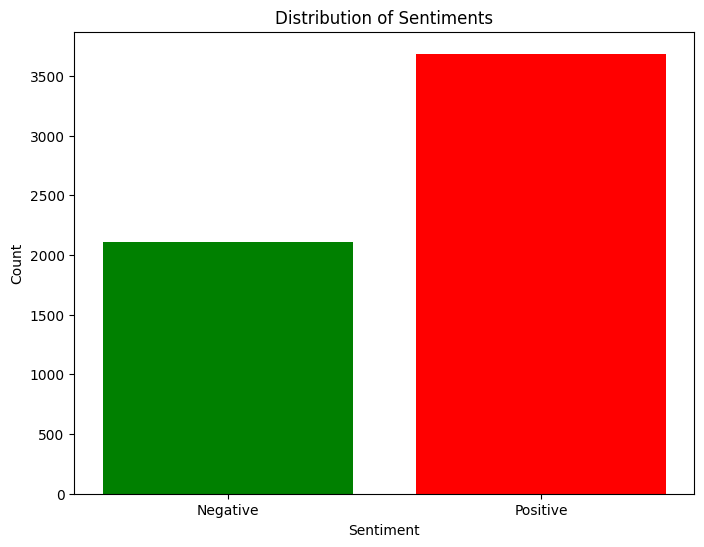

In [52]:
### Graphical Enhancements ###
# 4. Sentiment distribution as a bar chart (as done earlier)
plt.figure(figsize=(8, 6))
plt.bar(sentiment_counts.index, sentiment_counts.values, color=['red', 'green'])
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Negative', 'Positive'])
plt.show()

Split the data in Training and testing data

In [53]:
# Split the training and test data into 80/20 split
train_pct = .8
np.random.seed(1)
idx = np.random.permutation(len(data))

Model Training and Fitting

In [54]:
X_train = data['Text_Cleaned'].values[idx[:int(train_pct*len(data))]]
y_train = data['Sentiment'].values[idx[:int(train_pct*len(data))]]
y_train[y_train==-1] = 0


X_test = data['Text_Cleaned'].values[idx[int(train_pct*len(data)):]]
y_test = data['Sentiment'].values[idx[int(train_pct*len(data)):]]
y_test[y_test==-1] = 0

In [55]:
print(X_train.shape, y_train.shape )
print(X_test.shape, y_test.shape )

(4632,) (4632,)
(1159,) (1159,)


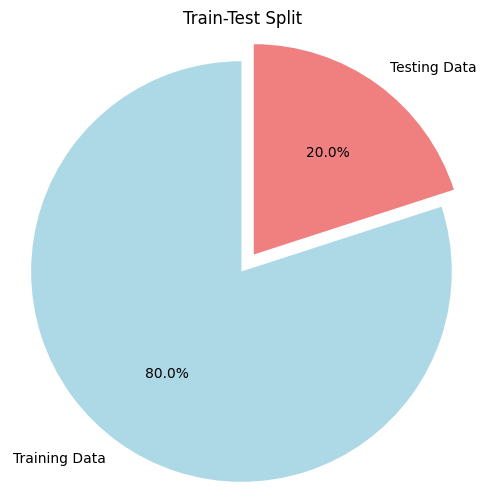

In [57]:
# Use the known sizes of training and testing datasets
train_size = len(X_train)  # 4632
test_size = len(X_test)    # 1159

# Create a pie chart to visualize the train-test split
plt.figure(figsize=(6, 6))
sizes = [train_size, test_size]
labels = ['Training Data', 'Testing Data']
colors = ['lightblue', 'lightcoral']
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90, explode=(0.1, 0))  # explode to highlight
plt.title('Train-Test Split')
plt.axis('equal')  # Equal aspect ratio ensures that the pie is drawn as a circle.
plt.show()

Tokenization

In [58]:
# Prepare the Bert NLP model tokenizer to encode tweets
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)


Encoding Tweets for Model

In [60]:
import torch

# Define the maximum length for BERT input
MAX_LEN = 128  # You can adjust this as needed

# Encode the tweets for the BERT model
def preprocessing_for_bert(data):
    input_ids = []
    attention_masks = []
    
    # For each tweet
    for line in data:
        # Encode the data. Return input encoding and attention mask
        encoding = tokenizer.encode_plus(
            text=line,                # Data to process
            add_special_tokens=True,  # Adds special chars [CLS] and [SEP] to encoding
            padding='max_length',     # Pad the tweets with 0s to fit max length
            max_length=MAX_LEN,       # Assign max length
            truncation=True,          # Truncate tweets longer than max length
            return_tensors="pt",     # Return tensor as PyTorch tensor
            return_attention_mask=True # Return the attention mask
        )

        # Add the encodings to the list
        input_ids.append(encoding['input_ids'])
        attention_masks.append(encoding['attention_mask'])
        
    # Return the lists as tensors
    input_ids = torch.cat(input_ids, dim=0)  # Concatenate along the first dimension
    attention_masks = torch.cat(attention_masks, dim=0)
    
    return input_ids, attention_masks


In [60]:
# Encode the tweets for Bert model
def preprocessing_for_bert(data):
    input_ids = []
    attention_masks = []
    
    # For each tweet
    for line in data:
        # encode the data. Return input encoding and attention mask
        encoding = tokenizer.encode_plus(
                text=line, # data to process
                add_special_tokens=True, # adds special chars [CLS] and [SEP] to encoding 
                padding='max_length', # pad the tweets with 0s to fit max length
                max_length = MAX_LEN, # assign max length
                truncation=True, # truncate tweets longer than max length
                return_tensors="pt", # return tensor as pytorch tensor
                return_attention_mask=True # return the attention mask
                )
        
    # add the encodings to the list
        input_ids.append(encoding.get('input_ids'))
        attention_masks.append(encoding.get('attention_mask'))
        
    # return the lists as tensors
    input_ids = torch.concat(input_ids)
    attention_masks = torch.concat(attention_masks)
    
    return input_ids, attention_masks

    

In [61]:
# Use this to determine max length for encoding
encoded = [tokenizer.encode(sent, add_special_tokens=True) for sent in data['Text_Cleaned'].values]
MAX_LEN = max([len(sent) for sent in encoded])
print('Max length: ', MAX_LEN)

Max length:  53


In [62]:

# Encode the tweets for Bert model
def preprocessing_for_bert(data):
    input_ids = []
    attention_masks = []
    
    # For each tweet
    for line in data:
        # encode the data. Return input encoding and attention mask
        encoding = tokenizer.encode_plus(
                text=line, # data to process
                add_special_tokens=True, # adds special chars [CLS] and [SEP] to encoding 
                padding='max_length', # pad the tweets with 0s to fit max length
                max_length = MAX_LEN, # assign max length
                truncation=True, # truncate tweets longer than max length
                return_tensors="pt", # return tensor as pytorch tensor
                return_attention_mask=True # return the attention mask
                )

        # add the encodings to the list
        input_ids.append(encoding.get('input_ids'))
        attention_masks.append(encoding.get('attention_mask'))
    
    # return the lists as tensors
    input_ids = torch.concat(input_ids)
    attention_masks = torch.concat(attention_masks)
    
    return input_ids, attention_masks


# Use this to determine max length for encoding
encoded = [tokenizer.encode(sent, add_special_tokens=True) for sent in data['Text_Cleaned'].values]
MAX_LEN = max([len(sent) for sent in encoded])
print('Max length: ', MAX_LEN)


# Encode the train and test data for Bert
X_train_inputs, X_train_masks = preprocessing_for_bert(X_train)
X_test_inputs, X_test_masks = preprocessing_for_bert(X_test)

# Get the train and test labels
y_train_labels = torch.tensor(y_train)
y_test_labels = torch.tensor(y_test)

print(X_train_inputs.shape, X_train_masks.shape, y_train_labels.shape)
print(X_test_inputs.shape, X_test_masks.shape, y_test_labels.shape)

# Set batch size to 16. recommended 16 or 32 depending on GPU size 
batch_size = 16

# Randomize the train data and define dataloader for model training 
train_data = TensorDataset(X_train_inputs, X_train_masks, y_train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Randomize the test data and define dataloader for model testing
test_data = TensorDataset(X_test_inputs, X_test_masks, y_test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

Max length:  53


ImportError: Unable to convert output to PyTorch tensors format, PyTorch is not installed.

Bert Model

In [12]:
# Define the Bert NLP Classifier
class BertClassifier(nn.Module):
    def __init__(self, freeze=False):
        super(BertClassifier, self).__init__()

        # Define the neurons for the final layer
        input_layer = 768
        hidden_layer = 50
        output_layer = 2

        # Use the pretrained Bert model for first section of NN
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Define a final layer to attach to the Bert model for custom classification
        self.classifier = nn.Sequential(
            nn.Linear(input_layer, hidden_layer), 
            nn.ReLU(), 
            nn.Linear(hidden_layer, output_layer))

        # Freeze the model from updating
        if freeze:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    # Return classification from Bert model 
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask)
        h_cls = outputs[0][:, 0, :]
        logits = self.classifier(h_cls)

        return logits
    
# Set random seed for repeatability
torch.manual_seed(1)
torch.cuda.manual_seed_all(1)
np.random.seed(1)

# Check if GPU is available and assign device 
if torch.cuda.is_available():       
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
# Initialize Bert Classifier
model = BertClassifier(freeze=False)

# Send model to device (GPU if available)
model.to(device)

# Define model hyperparameters
epochs = 4
steps = len(train_dataloader) * epochs
learning_rate = 5e-5
epsilon = 1e-8

# Define Adam optimizer
optimizer = AdamW(model.parameters(), lr=learning_rate, eps=epsilon)

# Define scheduler for training the optimizer 
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=steps)

# Define cross entropy loss function 
loss_function = nn.CrossEntropyLoss()

# For the number of epochs
for e in range(epochs):
    # Assign model to train
    model.train()

    # Intialize loss to zero
    train_loss = 0
    
    # For each batch
    for batch in train_dataloader:
        # Get batch inputs, masks and labels 
        batch_inputs, batch_masks, batch_labels = batch
        
        # Send variables to device (GPU if available)
        batch_inputs = batch_inputs.to(device)
        batch_masks = batch_masks.to(device)
        batch_labels = batch_labels.to(device)

        # Reset the model gradient
        model.zero_grad()

        # Get classification of encoded values
        logits = model(batch_inputs, batch_masks)
        
        # Calculate loss based on predictions and known values
        loss = loss_function(logits, batch_labels)
        
        # Add loss to the running total
        train_loss += loss.item()
        
        # Update the model weights based on the loss 
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    # Calculate the average loss over batch
    train_loss /= len(train_dataloader)
    
    # Assign the model to evaluate    
    model.eval()

    # Initialize losses
    test_loss = 0
    test_acc = 0

    # For each batch
    for batch in test_dataloader:
        # Get encoding inputs, masks and labels
        batch_inputs, batch_masks, batch_labels = batch
        
        # Send variables to device (GPU if available)
        batch_inputs = batch_inputs.to(device)
        batch_masks = batch_masks.to(device)
        batch_labels = batch_labels.to(device)

        # Predict the input values without updating the model 
        with torch.no_grad():
            logits = model(batch_inputs, batch_masks)

        # Calculate the loss
        loss = loss_function(logits, batch_labels)
        test_loss += loss.item()

        # Convert predictions to 0 and 1
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate accuracy of model on test data 
        accuracy = (preds == batch_labels).cpu().numpy().mean() * 100
        test_acc += accuracy

    # Calculate average loss and accuracy per each batch
    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

    # Print epoch information 
    print('Epoch: %d  |  Train Loss: %1.5f  |  Test Loss: %1.5f  |  Test Accuracy: %1.2f'%(e+1, train_loss, test_loss, test_acc))
    
# Save model
torch.save(model.state_dict(), 'stock_sentiment_model.pt')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: 1  |  Train Loss: 0.54333  |  Test Loss: 0.44172  |  Test Accuracy: 77.89
Epoch: 2  |  Train Loss: 0.30591  |  Test Loss: 0.43419  |  Test Accuracy: 83.11
Epoch: 3  |  Train Loss: 0.14389  |  Test Loss: 0.67964  |  Test Accuracy: 82.62
Epoch: 4  |  Train Loss: 0.06126  |  Test Loss: 0.82994  |  Test Accuracy: 83.19


In [4]:
import os
import datetime

# Get the list of stock data to convert
files = os.listdir('data/')

# for each stock files
for x in range(len(files)):
    # open the excel file on the Stream sheet
    stock = pd.read_excel('data/'+files[x] + '/export_dashboard_' + files[x], sheet_name='Stream')

    # Assign the ticker name as a column
    stock['Ticker'] = files[x].split('_')[0]
    
    # Convert string date times to datetime
    stock['Date'] = pd.to_datetime(stock['Date'])
    stock['Hour'] = stock['Hour'].apply(lambda t: pd.Timedelta(hours=int(t[:2]), minutes=int(t[3:])))
    stock['Datetime'] = stock['Date'] + stock['Hour']

    # Rename column that holds the tweets content
    stock.rename(columns = {'Tweet content':'Text'}, inplace = True)

    # Pre process the tweet content
    stock = preprocess.Preprocess_Tweets(stock)

    # Remove excess columns
    stock = stock[['Tweet Id', 'Ticker', 'Datetime', 'Text', 'Text_Cleaned', 'Favs', 'RTs', 'Followers', 'Following', 'Is a RT']]
    
    # Fill NAs in Favs, RTs, Followers and Following with 0
    stock = stock.fillna(0)

    # Encode processed tweets for Bert NLP model
    stock_inputs, stock_masks = preprocessing_for_bert(stock['Text_Cleaned'].values)

    # Put stock data in PyTorch dataloader for processing 
    stock_data = TensorDataset(stock_inputs, stock_masks)
    stock_sampler = RandomSampler(stock_data)
    stock_dataloader = DataLoader(stock_data, sampler=stock_sampler, batch_size=batch_size)

    # Assign model to evaluate 
    model.eval()

    predictions = []

    # For each batch
    for batch in stock_dataloader:
        # Get encoded inputs and masks 
        batch_inputs, batch_masks = batch

        # Send variables to device (GPU if available)
        batch_inputs = batch_inputs.to(device)
        batch_masks = batch_masks.to(device)

        # Predict classes with Bert for given inputs 
        with torch.no_grad():
            logits = model(batch_inputs, batch_masks)

        # Convert predictions to 0s and 1s
        preds = torch.argmax(logits, dim=1).flatten()
        predictions.append(preds)

    # Combine all batch predictions
    predictions = torch.cat(predictions).cpu().numpy()
    
    # Add predictions to stock dataframe
    stock['Sentiment'] = predictions
    
    # save predictions as new csv
    stock.to_csv('data/'+files[x] +'/stock_data_sentiment.csv', index=False)
    
    # Show stock names as they are completed 
    print(files[x].split('_')[0], '- completed')


aal - completed
aapl - completed
adbe - completed
adp - completed
adsk - completed
akam - completed
alxn - completed
amat - completed
amgn - completed
amzn - completed
atvi - completed
avgo - completed
bbby - completed
bidu - completed
bmrn - completed
ca - completed
celg - completed
cern - completed
chkp - completed
chtr - completed
cmcsa - completed
cost - completed
csco - completed
csx - completed
ctrp - completed
ctsh - completed
disca - completed
disck - completed
dish - completed
dltr - completed
ea - completed
ebay - completed
endp - completed
esrx - completed
expe - completed
fast - completed
fb - completed
fisv - completed
foxa - completed
fox - completed
gild - completed
googl - completed
goog - completed
hsic - completed
ilmn - completed
inct - completed
incy - completed
intu - completed
isrg - completed
jd - completed
khc - completed
lbtya - completed
lbtyk - completed
lltc - completed
lmca - completed
lmck - completed
lrcx - completed
lrcx - completed
lvnta - completed
mar

In [8]:
model.eval()

predictions = []

for batch in test_dataloader:
    batch_inputs, batch_masks, batch_labels = batch

    batch_inputs = batch_inputs.to(device)
    batch_masks = batch_masks.to(device)
    batch_labels = batch_labels.to(device)

    with torch.no_grad():
        logits = model(batch_inputs, batch_masks)


    preds = torch.argmax(logits, dim=1).flatten()
    predictions.append(preds)
        
predictions = torch.cat(predictions).cpu().numpy()

negatives = np.where(y_test==0)[0]
TNs = np.where( (y_test==0) & (y_test==predictions) )[0]
print(len(TNs)/len(negatives))

positives = np.where(y_test==1)[0]
TPs = np.where( (y_test==1) & (y_test==predictions) )[0]
print(len(TPs)/len(positives))

0.755011135857461
0.8802816901408451
